<a href="https://colab.research.google.com/github/lanzalibre/cold_start/blob/main/image_and_text_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/enrico310786/image_text_retrieval_BLIP_BLIP2.git

Cloning into 'image_text_retrieval_BLIP_BLIP2'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 96 (delta 1), reused 33 (delta 0), pack-reused 61
Receiving objects: 100% (96/96), 354.13 MiB | 24.66 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (36/36), done.


In [ ]:
!unzip ./pietanze.zip

Archive:  ./pietanze.zip
   creating: pietanze/
  inflating: pietanze/mappa.json     
  inflating: pietanze/.DS_Store      
   creating: pietanze/dolce/
  inflating: pietanze/dolce/bigne_1.jpg  
  inflating: pietanze/dolce/.DS_Store  
  inflating: pietanze/dolce/tiramisu_2.jpeg  
  inflating: pietanze/dolce/bigne_2.jpg  
  inflating: pietanze/dolce/bigne_3.jpg  
  inflating: pietanze/dolce/baba_1.jpeg  
  inflating: pietanze/dolce/crostata_1.jpg  
  inflating: pietanze/dolce/crostata_3.jpg  
  inflating: pietanze/dolce/crostata_2.jpg  
  inflating: pietanze/dolce/baba_2.jpg  
  inflating: pietanze/dolce/baba_3.jpg  
  inflating: pietanze/dolce/panna_cotta_1.jpeg  
  inflating: pietanze/dolce/panna_cotta_2.jpg  
  inflating: pietanze/dolce/panna_cotta_3.jpg  
  inflating: pietanze/dolce/tiramisu_1.jpg  
  inflating: pietanze/dolce/tiramisu_3.jpg  
  inflating: pietanze/dolce/millefoglie_1.jpg  
  inflating: pietanze/dolce/millefoglie_2.jpg  
  inflating: pietanze/dolce/millefoglie_3.jpg

In [ ]:
%ls

BLIP2_LAVIS_finetuned_coco.ipynb  BLIP_LAVIS_basemodel.ipynb       pietanze.zip
BLIP2_LAVIS_pretrain.ipynb        BLIP_LAVIS_finetuned_coco.ipynb  similarity_matrices/
BLIP2_LAVIS_pretrain_VitL.ipynb   list_images_descriptions.png     test_images/


In [ ]:
!pip install deep-translator salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 21.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
from tqdm import tqdm
import torch
import torch.nn.functional as F
from pkg_resources import packaging
from glob import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_theme("notebook", font_scale=1.3)
import os
import json
from deep_translator import GoogleTranslator
from scipy import spatial

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import numpy as np, matplotlib, matplotlib.pyplot as plt, seaborn as sns

In [ ]:
import json
image_map = None
with open('pietanze/mappa.json', 'r') as f:
    image_map = json.load(f)

In [ ]:
# Functions

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


Using device: cpu



In [ ]:
def translate_caption(string):
    try:
        #print('ita_string: ', string)
        string_translated = GoogleTranslator(source='auto', target='en').translate(string)
        #print('string_translated: ', string_translated)
        return string_translated
    except Exception as e:
        string_translated = ''
        print("Errore per ita_string '{}' - caption '{}' - errore: {}".format(string))
        return string_translated

def transform_image(image, image_size):

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(image)
    return image

# Load images and texts

Read the map with the path to the images and their corresponding descriptions. Put the images and the descriptions in the lists "images" and "texts". Show images, description and name in a figure

In [ ]:
principal_dir = "./pietanze"

images = []
texts = []
names_image = []
original_texts = []
#plt.figure(figsize=(300, 300)) # Width, height

# iter over the dishes
for _, dishes, _ in os.walk(principal_dir):
    for dish in dishes:
        path_dish = os.path.join(principal_dir, dish)
        CHECK_FOLDER = os.path.isdir(path_dish)
        if CHECK_FOLDER:
            print("DISH: ", dish)
            print("PATH DISH: ", path_dish)

            images_list = os.listdir(path_dish)
            print("images_list: ", images_list)
            for name_image in images_list:
                if name_image != ".DS_Store" and name_image != ".ipynb_checkpoints":
                    path_image = os.path.join(path_dish, name_image)
                    chiave = ("/").join(path_image.split("/")[1:])
                    image = Image.open(path_image).convert("RGB")
                    origninal_text = image_map[chiave]
                    text = translate_caption(origninal_text)

                    #plt.subplot(len(image_map), 1, len(images) + 1)
                    #plt.imshow(image)
                    #plt.title(f"{name_image}\n{text}")
                    #plt.xticks([])
                    #plt.yticks([])

                    images.append(image)
                    texts.append(text)
                    names_image.append(name_image)
                    original_texts.append(origninal_text)

            print("----------------------------------")

DISH:  pasta
PATH DISH:  ./pietanze/pasta
images_list:  ['carbonara_1.jpg', 'pasta_amatriciana_1.jpg', 'pasta_amatriciana_2.jpg', 'carbonara_3.jpeg', 'pasta_pesto_1.jpg', 'pasta_norma_2.jpg', 'pappardelle_cinghiale_2.jpg', 'pasta_norma_1.jpeg', 'carbonara_2.jpg', 'pasta_pomodoro_3.jpg', 'pappardelle_cinghiale.jpeg', '.DS_Store', 'pasta_amatriciana_3.jpg', 'pasta_pomodoro_2.jpg', 'pasta_pesto_2.jpg']
----------------------------------
DISH:  dolce
PATH DISH:  ./pietanze/dolce
images_list:  ['bigne_1.jpg', 'baba_3.jpg', 'panna_cotta_2.jpg', 'panna_cotta_1.jpeg', 'millefoglie_1.jpg', 'baba_1.jpeg', 'crostata_2.jpg', 'crostata_1.jpg', 'baba_2.jpg', '.DS_Store', 'millefoglie_2.jpg', 'bigne_2.jpg', 'panna_cotta_3.jpg', 'crostata_3.jpg', 'tiramisu_3.jpg', 'millefoglie_3.jpg', 'bigne_3.jpg', 'tiramisu_2.jpeg', 'tiramisu_1.jpg']
----------------------------------
DISH:  carne
PATH DISH:  ./pietanze/carne
images_list:  ['porchetta_1.jpg', 'petto_pollo_pizzaiola.jpg', 'vitello_tonnato_1.jpg', 'bi

#Apply BLIP2 from LAVIS lib - images, text and multimodal embedding

In [ ]:
from lavis.models import load_model_and_preprocess
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="coco", is_eval=True, device=device)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.89G/1.89G [01:07<00:00, 29.8MB/s]


Position interpolate from 16x16 to 26x26


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 4.37G/4.37G [03:54<00:00, 20.0MB/s]


#Extraction of the embeddings

In [ ]:
images_embedding = None
texts_embedding = None
multimodal_embedding = None

# iter over the list of text and images

for text, image in zip(texts,images):
    image_processed = vis_processors["eval"](image).unsqueeze(0).to(device)
    text_translated = translate_caption(text)
    text_input = txt_processors["eval"](text_translated)
    sample = {"image": image_processed, "text_input": [text_input]}

    multimodal_emb = model.extract_features(sample).multimodal_embeds[:,0,:] # size (1, 768)
    image_emb = model.extract_features(sample, mode="image").image_embeds[:,0,:] # size (1, 768)
    text_emb = model.extract_features(sample, mode="text").text_embeds[:,0,:] # size (1, 768)

    # stack tensor
    if images_embedding is None:
        images_embedding = image_emb
    else:
       images_embedding = torch.cat((images_embedding, image_emb),0)

    if texts_embedding is None:
        texts_embedding = text_emb
    else:
       texts_embedding = torch.cat((texts_embedding, text_emb),0)

    if multimodal_embedding is None:
        multimodal_embedding = multimodal_emb
    else:
       multimodal_embedding = torch.cat((multimodal_embedding, multimodal_emb),0)

print('images_embedding.size(): ', images_embedding.size())
print('texts_embedding.size(): ', texts_embedding.size())
print('multimodal_embedding.size(): ', multimodal_embedding.size())

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


images_embedding.size():  torch.Size([68, 768])
texts_embedding.size():  torch.Size([68, 768])
multimodal_embedding.size():  torch.Size([68, 768])


#Normalization
Divide each tensors by its norm. In this way when i calculate the dot product between two tensors i directly obtain the cosin between the two

In [ ]:
images_embedding /= images_embedding.norm(dim=-1, keepdim=True)
texts_embedding /= texts_embedding.norm(dim=-1, keepdim=True)
multimodal_embedding /= multimodal_embedding.norm(dim=-1, keepdim=True)

#Similarity matrices

In [ ]:
## image vs image
similarity_images = images_embedding.cpu().detach().numpy() @ images_embedding.cpu().detach().numpy().T
similarity_images_texts = images_embedding.cpu().detach().numpy() @ texts_embedding.cpu().detach().numpy().T
similarity_multimodal = multimodal_embedding.cpu().detach().numpy() @ multimodal_embedding.cpu().detach().numpy().T
similarity_images_multimodal = images_embedding.cpu().detach().numpy() @ multimodal_embedding.cpu().detach().numpy().T


function to plot the similarity matrixfor the plot i use https://stackoverflow.com/questions/67310634/how-to-plot-image-image-similarity-matrix-map

In [ ]:
def ImgLabels(N, ax):

    def offset_image(coord, image_plot, ax):

        im = matplotlib.offsetbox.OffsetImage(image_plot, zoom = 1)
        im.image.axes = ax

        for co, xyb in [((0, coord), (-30, -30)),    ((coord, N), (+30, -30))]: # these number have to be adjusted if change the image dimension as well as the number of examples
            ab = matplotlib.offsetbox.AnnotationBbox(im, co,  xybox = xyb,
                frameon=False, xycoords='data',  boxcoords="offset points", pad=0)
            ax.add_artist(ab)

    for i, img in enumerate(images):
        image_resized = img.resize((55, 55))
        offset_image(i, image_resized, ax)

def HeatMap(N, corr):
    sns.set_theme(style = "white")
    mask = np.triu(np.ones_like(corr, dtype = bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, annot = True, xticklabels = False, yticklabels = False)


def plot_similarity_matrix(matrix, dimension, name_fig):
    f, ax = plt.subplots(figsize=(100, 100))
    HeatMap(dimension, matrix)
    ImgLabels(dimension, ax)
    plt.savefig("/content/gdrive/MyDrive/Colab Notebooks/LAVIS/search_pietanze/similarity_matrices/"+name_fig+".png")
    plt.show()

In [ ]:
#Image-image similarity

name_fig = "images_blip2_coco"
plot_similarity_matrix(similarity_images, 68, name_fig)


FileNotFoundError: ignored

#Search function
search_modality: (II for image vs image - TI for text vs image - MI for multimodal vs image - IT for image vs text - TT for text vs text - MT for multimodal vs text - IM for image vs multimodal - TM for text vs multimodal - MM for multimodal vs multimodal). The first argument refers to the target product the second for the database product

In [32]:
def search_similar_product(image_target, text_target, number_retrieval, search_modality, len_dataset = 68, is_coco_finetuned = False):

    retrieval_map = {}

    # preprocess image. check if the image is None. In this case build a tensor with shape (1, 3, 224, 224)
    if image_target is None:
        if is_coco_finetuned:
            image_processed = torch.rand(1, 3, 364, 364).to(device)
        else:
            image_processed = torch.rand(1, 3, 224, 224).to(device)
    else:
      image_processed = vis_processors["eval"](image_target).unsqueeze(0).to(device)

    # preprocess text
    text_translated = translate_caption(text_target)
    text_input = txt_processors["eval"](text_translated)

    # build sample
    sample = {"image": image_processed, "text_input": [text_input]}

    # find features of image and text target
    multimodal_emb = model.extract_features(sample).multimodal_embeds[0,0,:] # size (768)
    image_emb = model.extract_features(sample, mode="image").image_embeds[0,0,:] # size (768)
    text_emb = model.extract_features(sample, mode="text").text_embeds[0,0,:] # size (768)

    # normalize
    image_emb /= image_emb.norm(dim=-1, keepdim=True)
    text_emb /= text_emb.norm(dim=-1, keepdim=True)
    multimodal_emb /= multimodal_emb.norm(dim=-1, keepdim=True)

    # transform to numpy tensor
    image_emb = image_emb.cpu().detach().numpy()
    text_emb = text_emb.cpu().detach().numpy()
    multimodal_emb = multimodal_emb.cpu().detach().numpy()

    if search_modality == "II":
      similarity_vector = images_embedding.cpu().detach().numpy() @ image_emb.T
    elif search_modality == "TI":
      similarity_vector = images_embedding.cpu().detach().numpy() @ text_emb.T
    elif search_modality == "MI":
      similarity_vector = images_embedding.cpu().detach().numpy() @ multimodal_emb.T

    elif search_modality == "IT":
      similarity_vector = texts_embedding.cpu().detach().numpy() @ image_emb.T
    elif search_modality == "TT":
      similarity_vector = texts_embedding.cpu().detach().numpy() @ text_emb.T
    elif search_modality == "MT":
      similarity_vector = texts_embedding.cpu().detach().numpy() @ multimodal_emb.T

    elif search_modality == "IM":
      similarity_vector = multimodal_embedding.cpu().detach().numpy() @ image_emb.T
    elif search_modality == "TM":
      similarity_vector = multimodal_embedding.cpu().detach().numpy() @ text_emb.T
    elif search_modality == "MM":
      similarity_vector = multimodal_embedding.cpu().detach().numpy() @ multimodal_emb.T

    index_sorted = np.argsort(similarity_vector)

    for i in range(1, number_retrieval+1):

        print("Extracted: ", i)

        # index of the db product
        idx = index_sorted[len_dataset-i]
        similarity_value = similarity_vector[idx]

        print("idx: ", idx)
        print("similarity value: ", similarity_value)

        # extract name of the image
        name_image_found = names_image[idx]
        print("name_image_found: ", name_image_found)
        print("-----------------------")

        # extract text of the image
        text_image_found = original_texts[idx]
        translated_text_image_found = texts[idx]

        # extract image
        image_found = images[idx]

        #fill the extracted infos in the map
        retrieval_map[i] = (image_found, name_image_found, text_image_found, translated_text_image_found, similarity_value)

    return retrieval_map

In [35]:
!ls

BLIP2_LAVIS_finetuned_coco.ipynb  BLIP_LAVIS_basemodel.ipynb	   pietanze		test_images
BLIP2_LAVIS_pretrain.ipynb	  BLIP_LAVIS_finetuned_coco.ipynb  pietanze.zip
BLIP2_LAVIS_pretrain_VitL.ipynb   list_images_descriptions.png	   similarity_matrices


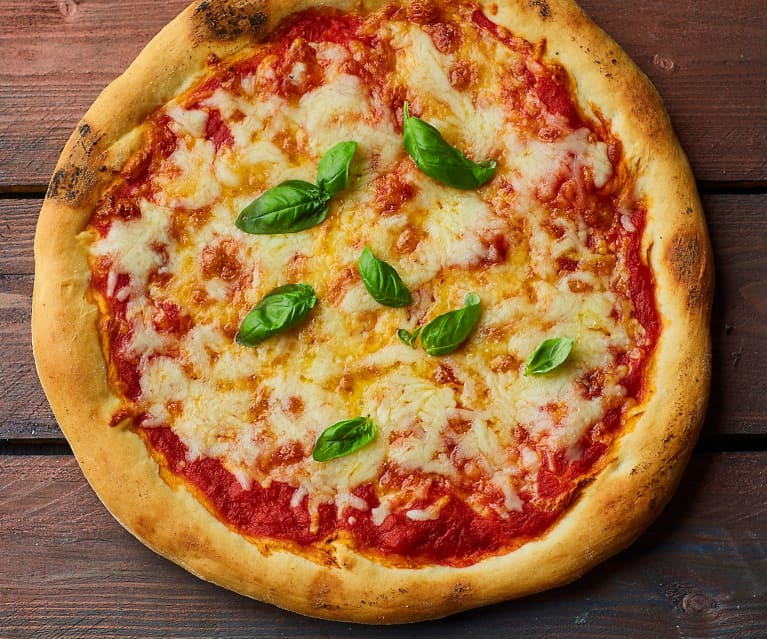

In [36]:
path_image_target = "test_images/pizza_marghetita_test.jpg"
text_image_target = ""
number_retrieval = 3
raw_image = Image.open(path_image_target).convert("RGB")
display(raw_image)

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Extracted:  1
idx:  61
similarity value:  0.9107037
name_image_found:  pizza_margherita_2.jpg
-----------------------
Extracted:  2
idx:  64
similarity value:  0.89512956
name_image_found:  pizza_margherita_1.jpg
-----------------------
Extracted:  3
idx:  55
similarity value:  0.7973611
name_image_found:  pizza_quattro_formaggi_2.jpg
-----------------------


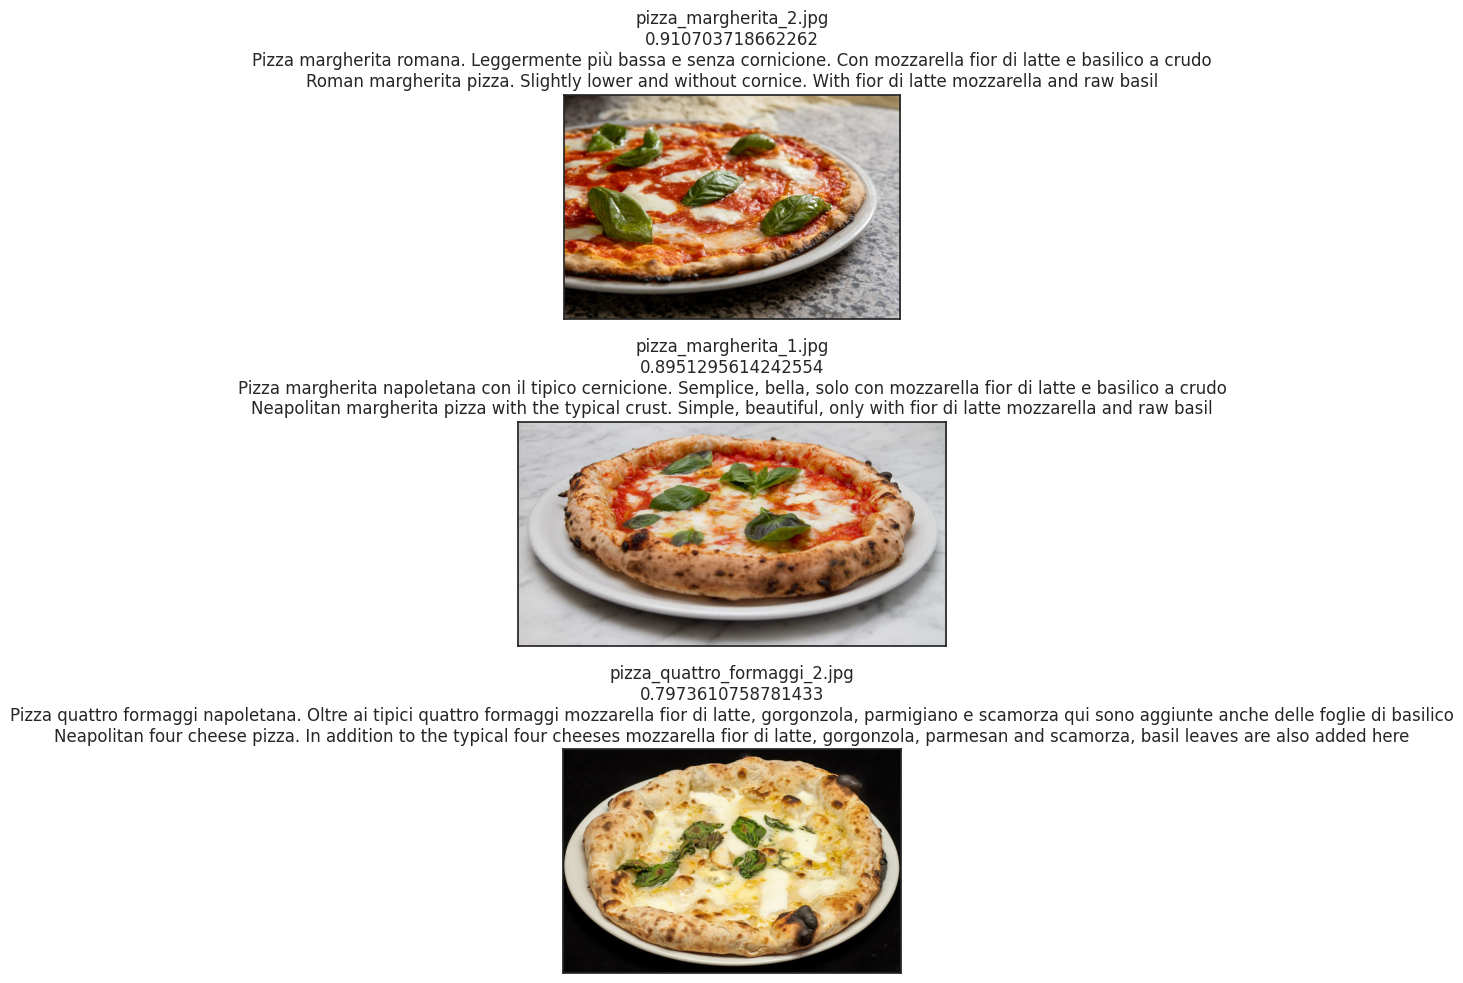

In [37]:
retrieval_map = search_similar_product(image_target=raw_image,
                                       text_target=text_image_target,
                                       number_retrieval=number_retrieval,
                                       search_modality="II")


plt.figure(figsize=(10, 10))
for i in range(1, len(retrieval_map)+1):

    image, name_image, text, translated_text, similarity_value = retrieval_map[i]
    plt.subplot(number_retrieval, 1, i)
    plt.imshow(image)
    plt.title(f"{name_image}\n{similarity_value}\n{text}\n{translated_text}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()